In [1]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model

# --------- 1) Charger et aligner ----------
path = "./RNGWHHDd.xlsx"  # <-- change le nom de fichier si besoin
spot = pd.read_excel(path, sheet_name="NG Spots")
fut  = pd.read_excel(path, sheet_name="NGc1")

# Normaliser les noms
spot = spot.rename(columns={col: col.strip() for col in spot.columns})
fut  = fut.rename(columns={col: col.strip() for col in fut.columns})

# Assurer le type date et garder les colonnes utiles
spot["Date"] = pd.to_datetime(spot["Date"])
fut["Date"]  = pd.to_datetime(fut["Date"])
spot = spot[["Date", "r_spot"]].dropna()
fut  = fut[["Date", "r_fut"]].dropna()

# Merge sur dates communes
df = pd.merge(spot, fut, on="Date", how="inner").sort_values("Date").reset_index(drop=True)
dh=df.copy()  
# Option : enlever les jours de retour 0 absolu (si tu en as créés par erreur)
# df = df[(df["r_spot"] != 0) | (df["r_fut"] != 0)]

# --------- 2) Fonction d'estimation OLS ----------
def estimate_mvhr_ols(data, start=None, end=None, hac_lags=5):
    """
    data: DataFrame avec colonnes r_spot, r_fut, Date
    start/end: limites temporelles (str 'YYYY-MM-DD' ou Timestamp) pour un régime
    hac_lags: lags Newey-West pour erreurs robustes (autocorrélation/hétéro)
    Retourne: dict avec beta (h*), alpha, t-stats, R2, n
    """
    d = data.copy()
    if start is not None:
        d = d[d["Date"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["Date"] <= pd.to_datetime(end)]
    d = d.dropna(subset=["r_spot", "r_fut"])

    # X = r_fut, y = r_spot
    X = sm.add_constant(d["r_fut"].values)   # ajoute l'intercept alpha
    y = d["r_spot"].values

    model = sm.OLS(y, X, missing="drop")
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})  # Newey-West

    alpha = res.params[0]
    beta  = res.params[1]                 # <-- h* (hedge ratio)
    t_a   = res.tvalues[0]
    t_b   = res.tvalues[1]
    r2    = res.rsquared
    n     = int(res.nobs)

    return {
        "alpha": alpha,
        "beta_hstar": beta,
        "t_alpha": t_a,
        "t_beta": t_b,
        "R2": r2,
        "n": n
    }

# --------- 3) Exemple d’appels ----------
# a) Un seul hedge ratio sur toute la période disponible
res_all = estimate_mvhr_ols(df)
print("Global  :", res_all)

# b) Par régimes (exemple : Katrina/Rita, à adapter si tu choisis d’autres bornes)
res_pre  = estimate_mvhr_ols(df, start="2003-01-01", end="2005-07-31")
res_cris = estimate_mvhr_ols(df, start="2005-08-01", end="2005-12-31")
res_post = estimate_mvhr_ols(df, start="2006-01-01", end="2007-12-31")
print("Pré-crise :", res_pre)
print("Crise     :", res_cris)
print("Post-crise:", res_post)

# --------- 4) (Option) Rolling OLS pour voir la dérive de beta (si tu veux) ----------
def rolling_beta(data, window=60, hac_lags=0):
    """
    Calcule un beta OLS roulant (sans HAC par défaut pour la vitesse).
    Retourne un DataFrame avec Date (fin de fenêtre) et beta.
    """
    out = []
    d = data.dropna(subset=["r_spot", "r_fut"]).reset_index(drop=True)
    for i in range(window, len(d)):
        sub = d.iloc[i-window:i]
        X = sm.add_constant(sub["r_fut"].values)
        y = sub["r_spot"].values
        res = sm.OLS(y, X).fit() if hac_lags==0 else sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
        out.append({"Date": d.loc[i, "Date"], "beta_hstar": res.params[1]})
    return pd.DataFrame(out)

# Exemple rolling (facultatif)
beta_roll = rolling_beta(df, window=60)
print(beta_roll.tail())

Global  : {'alpha': 0.0001667844868680497, 'beta_hstar': 0.3792009233560551, 't_alpha': 0.2804670502459635, 't_beta': 6.44902288451576, 'R2': 0.06092394712666682, 'n': 4858}
Pré-crise : {'alpha': 0.00037895279789887745, 'beta_hstar': 0.5636458579760798, 't_alpha': 0.2837399512474878, 't_beta': 2.481509408364184, 'R2': 0.14257869568390735, 'n': 644}
Crise     : {'alpha': -0.00017066036445889513, 'beta_hstar': 0.7158065010947079, 't_alpha': -0.03837620067228319, 't_beta': 6.279094256562554, 'R2': 0.22869308946143474, 'n': 96}
Post-crise: {'alpha': -0.00026837495394322166, 'beta_hstar': 0.38824415665638445, 't_alpha': -0.18401192341765207, 't_beta': 5.083651210492943, 'R2': 0.09832276332230139, 'n': 501}
           Date  beta_hstar
4793 2022-05-13    0.308302
4794 2022-05-16    0.310673
4795 2022-05-17    0.342715
4796 2022-05-18    0.344560
4797 2022-05-19    0.335123


In [2]:


def subset(df, start=None, end=None):
    d = df.copy()
    if start is not None:
        d = d[d["Date"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["Date"] <= pd.to_datetime(end)]
    return d.dropna(subset=["r_spot", "r_fut"]).reset_index(drop=True)

def hedged_returns(d, h):
    """ r_H = r_spot - h * r_fut """
    out = d.copy()
    out["r_H"] = out["r_spot"] - h * out["r_fut"]
    return out

def hedge_effectiveness(d):
    """ HE = 1 - Var(r_H)/Var(r_spot) (variance empirique, ddof=1) """
    var_spot = np.var(d["r_spot"], ddof=1)
    var_hedg = np.var(d["r_H"],   ddof=1)
    return 1.0 - (var_hedg / var_spot)

# --- Définis clairement les fenêtres des trois régimes ---
pre_start, pre_end   = "2003-01-01", "2005-07-31"
cris_start, cris_end = "2005-08-01", "2005-12-31"
post_start, post_end = "2006-01-01", "2007-12-31"


h_pre, h_cris, h_post = res_pre["beta_hstar"], res_cris["beta_hstar"], res_post["beta_hstar"]

# --- 2) Construire r_H et calculer HE dans chaque régime (avec h* du même régime) ---
def eval_regime_HE(df, start, end, h, label):
    d = subset(df, start, end)
    dH = hedged_returns(d, h)
    HE = hedge_effectiveness(dH)
    return {"regime": label, "start": start, "end": end, "n": len(dH), "h_used": h, "HE": HE}

res_HE_pre  = eval_regime_HE(df, pre_start,  pre_end,  h_pre,  "Pré-crise (OLS du régime)")
res_HE_cris = eval_regime_HE(df, cris_start, cris_end, h_cris, "Crise (OLS du régime)")
res_HE_post = eval_regime_HE(df, post_start, post_end, h_post, "Post-crise (OLS du régime)")

# --- 3) Tableau récap propre (uniquement les 3 HE demandés) ---
table_HE = pd.DataFrame([res_HE_pre, res_HE_cris, res_HE_post])[
    ["regime", "start", "end", "n", "h_used", "HE"]
].reset_index(drop=True)

print("\n=== Hedge Effectiveness (HE) — OLS par régime ===")
print(table_HE.to_string(index=False))


=== Hedge Effectiveness (HE) — OLS par régime ===
                    regime      start        end   n   h_used       HE
 Pré-crise (OLS du régime) 2003-01-01 2005-07-31 644 0.563646 0.142579
     Crise (OLS du régime) 2005-08-01 2005-12-31  96 0.715807 0.228693
Post-crise (OLS du régime) 2006-01-01 2007-12-31 501 0.388244 0.098323


In [3]:
# --- 1-to-1 Hedge Ratio Evaluation ---
# This assumes a hedge ratio of 1 (h = 1) and evaluates its effectiveness by regime.

def eval_1to1_hedge(df, start, end, label):
    """
    Evaluate the effectiveness of a 1-to-1 hedge ratio (h = 1) for a specific regime.
    Args:
        df: DataFrame with columns 'Date', 'r_spot', 'r_fut'.
        start: Start date of the regime (string or Timestamp).
        end: End date of the regime (string or Timestamp).
        label: Label for the regime (string).
    Returns:
        dict: Results including regime label, start/end dates, number of observations, hedge ratio used, and HE.
    """
    # Subset the data for the given regime
    d = subset(df, start, end)
    
    # Apply the 1-to-1 hedge ratio (h = 1)
    dH = hedged_returns(d, h=1)
    
    # Calculate hedge effectiveness (HE)
    HE = hedge_effectiveness(dH)
    
    # Return results as a dictionary
    return {"regime": label, "start": start, "end": end, "n": len(dH), "h_used": 1, "HE": HE}

# --- Evaluate 1-to-1 Hedge Effectiveness for Each Regime ---
res_1to1_pre  = eval_1to1_hedge(df, pre_start,  pre_end,  "Pré-crise (1-to-1)")
res_1to1_cris = eval_1to1_hedge(df, cris_start, cris_end, "Crise (1-to-1)")
res_1to1_post = eval_1to1_hedge(df, post_start, post_end, "Post-crise (1-to-1)")

# --- Combine Results into a Summary Table ---
table_1to1_HE = pd.DataFrame([res_1to1_pre, res_1to1_cris, res_1to1_post])[
    ["regime", "start", "end", "n", "h_used", "HE"]
].reset_index(drop=True)

# Print the results for the 1-to-1 hedge ratio
print("\n=== Hedge Effectiveness (HE) — 1-to-1 Hedge Ratio ===")
print(table_1to1_HE.to_string(index=False))




=== Hedge Effectiveness (HE) — 1-to-1 Hedge Ratio ===
             regime      start        end   n  h_used        HE
 Pré-crise (1-to-1) 2003-01-01 2005-07-31 644       1  0.057127
     Crise (1-to-1) 2005-08-01 2005-12-31  96       1  0.192644
Post-crise (1-to-1) 2006-01-01 2007-12-31 501       1 -0.145796


In [4]:
from arch import arch_model
import pandas as pd

def estimate_garch_hedge_ratio_direct(df):
    """
    Estimate the hedge ratio directly using a GARCH(1,1) model with ARX mean specification.
    
    Args:
        df: DataFrame with columns 'r_spot' and 'r_fut'.
        
    Returns:
        float: Hedge ratio estimated within the GARCH(1,1) model.
    """
    # Remove any missing values and reset index
    df = df.dropna(subset=["r_spot", "r_fut"]).reset_index(drop=True)
    
    # Scale data by 1000 for improved numerical stability during estimation
    scale_factor = 1000
    r_spot_scaled = df["r_spot"] * scale_factor
    r_fut_scaled = df["r_fut"] * scale_factor
    
    # Prepare exogenous variable (futures returns) as 2D array for arch_model
    exog_data = r_fut_scaled.values.reshape(-1, 1)
    
    # Specify GARCH(1,1) model with ARX mean equation: r_spot = alpha + beta*r_fut + error
    # ARX allows inclusion of exogenous variables in the mean equation
    model = arch_model(r_spot_scaled, x=exog_data, vol="Garch", p=1, q=1, mean="ARX", lags=0)
    
    # Estimate model parameters using maximum likelihood
    garch_res = model.fit(disp="off")
    
    
    # Extract hedge ratio (beta coefficient of futures returns)
    # Parameter order: [0] = constant, [1] = beta (hedge ratio), [2+] = GARCH parameters
    hedge_ratio = garch_res.params.iloc[1]
    
    return hedge_ratio

def eval_garch_hedge(df, start, end, label):
    """
    Evaluate hedge effectiveness using GARCH(1,1) estimated hedge ratio for a specific time period.
    
    Args:
        df: DataFrame with columns 'Date', 'r_spot', 'r_fut'.
        start: Start date of the regime (string or Timestamp).
        end: End date of the regime (string or Timestamp).
        label: Label for the regime (string).
        
    Returns:
        dict: Results including regime label, dates, sample size, hedge ratio, and effectiveness.
    """
    # Extract data subset for the specified time period
    d = subset(df, start, end)
    
    # Estimate optimal hedge ratio using GARCH(1,1) model
    h_garch = estimate_garch_hedge_ratio_direct(d)
    
    # Construct hedged portfolio returns using estimated hedge ratio
    dH = hedged_returns(d, h_garch)
    
    # Calculate hedge effectiveness metric
    HE = hedge_effectiveness(dH)
    
    # Return comprehensive results as dictionary
    return {"regime": label, "start": start, "end": end, "n": len(dH), "h_used": h_garch, "HE": HE}

# === MAIN ANALYSIS: Evaluate GARCH hedge effectiveness across different market regimes ===

# Estimate hedge effectiveness for pre-crisis period
res_garch_pre = eval_garch_hedge(df, pre_start, pre_end, "Pré-crise (GARCH)")

# Estimate hedge effectiveness for crisis period
res_garch_cris = eval_garch_hedge(df, cris_start, cris_end, "Crise (GARCH)")

# Estimate hedge effectiveness for post-crisis period
res_garch_post = eval_garch_hedge(df, post_start, post_end, "Post-crise (GARCH)")

# Consolidate results into summary table
table_garch_HE = pd.DataFrame([res_garch_pre, res_garch_cris, res_garch_post])[
    ["regime", "start", "end", "n", "h_used", "HE"]
].reset_index(drop=True)

# Display final results
print("\n=== Hedge Effectiveness (HE) — GARCH(1,1) with ARX Mean Specification ===")
print(table_garch_HE.to_string(index=False))


=== Hedge Effectiveness (HE) — GARCH(1,1) with ARX Mean Specification ===
            regime      start        end   n   h_used       HE
 Pré-crise (GARCH) 2003-01-01 2005-07-31 644 0.382225 0.127807
     Crise (GARCH) 2005-08-01 2005-12-31  96 0.817988 0.224033
Post-crise (GARCH) 2006-01-01 2007-12-31 501 0.410240 0.098007


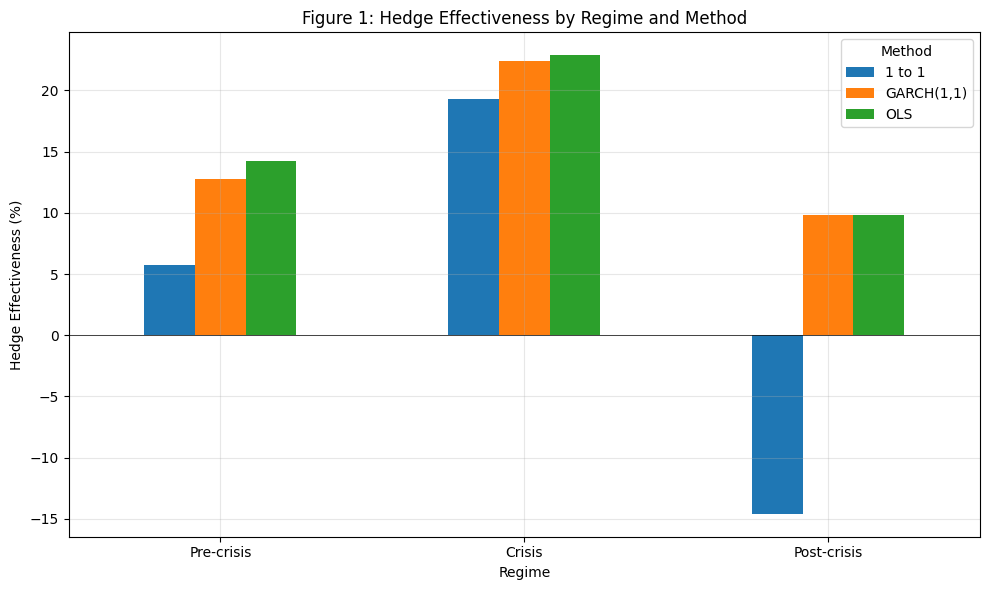

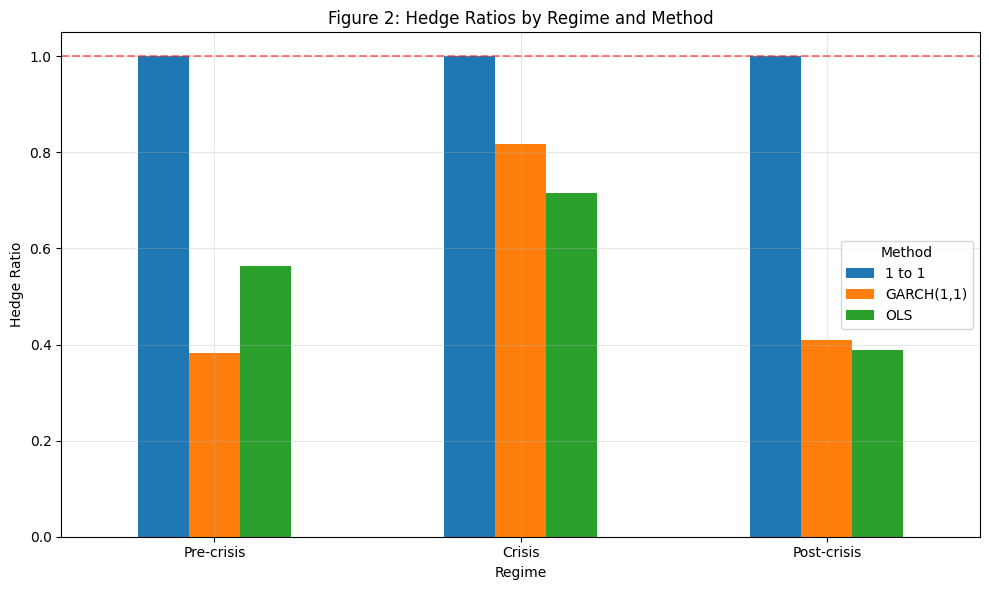

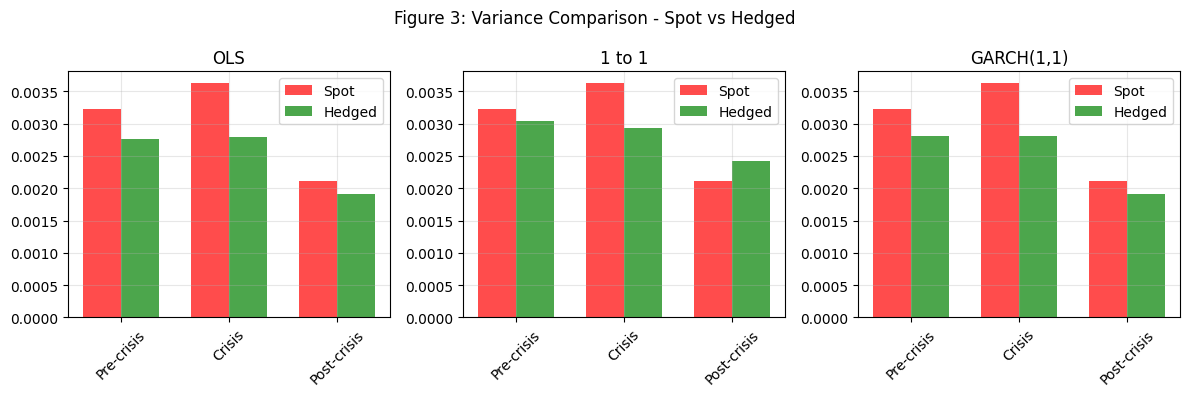


RÉSUMÉ

Hedge Effectiveness (%):
Method       1 to 1  GARCH(1,1)    OLS
Regime                                
Pre-crisis     5.71       12.78  14.26
Crisis        19.26       22.40  22.87
Post-crisis  -14.58        9.80   9.83

Hedge Ratios:
Method       1 to 1  GARCH(1,1)       OLS
Regime                                   
Pre-crisis      1.0    0.382225  0.563646
Crisis          1.0    0.817988  0.715807
Post-crisis     1.0    0.410240  0.388244

🏆 Meilleure méthode par régime:
Pre-crisis: OLS (14.26%)
Crisis: OLS (22.87%)
Post-crisis: OLS (9.83%)

⚠️ Point important: La méthode '1 to 1' a une HE négative
en post-crise (-14.58%), ce qui signifie qu'elle augmente
la variance au lieu de la réduire!


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def get_spot_variances(df):
    """
    Calcule les variances spot par période.
    
    Args:
        df: DataFrame avec colonnes 'Date', 'r_spot', 'r_fut'
    
    Returns:
        dict: {'Pre-crisis': var, 'Crisis': var, 'Post-crisis': var}
    """
    
    # Périodes
    pre = subset(dh, "2003-01-01", "2005-07-31")
    crisis = subset(dh, "2005-08-01", "2005-12-31")
    post = subset(dh, "2006-01-01", "2007-12-31")
    
    # Variances
    return {
        'Pre-crisis': np.var(pre["r_spot"], ddof=1),
        'Crisis': np.var(crisis["r_spot"], ddof=1),
        'Post-crisis': np.var(post["r_spot"], ddof=1)
    }

# Créer les données directement (fuck le fichier Excel problématique)
data = {
    'Regime': ['Pre-crisis']*3 + ['Crisis']*3 + ['Post-crisis']*3,
    'Method': ['OLS', '1 to 1', 'GARCH(1,1)']*3,
    'Hedge_Ratio': [0.563646, 1.0, 0.382225, 
                    0.715807, 1.0, 0.817988,
                    0.388244, 1.0, 0.41024],
    'HE': [14.26, 5.71, 12.78,
           22.87, 19.26, 22.40,
           9.83, -14.58, 9.80]
}



df = pd.DataFrame(data)

# Créer les pivots
pivot_he = df.pivot(index='Regime', columns='Method', values='HE')
pivot_hr = df.pivot(index='Regime', columns='Method', values='Hedge_Ratio')

# Ordre des régimes
regimes = ['Pre-crisis', 'Crisis', 'Post-crisis']
pivot_he = pivot_he.reindex(regimes)
pivot_hr = pivot_hr.reindex(regimes)

# FIGURE 1: Hedge Effectiveness
fig, ax = plt.subplots(figsize=(10, 6))
pivot_he.plot(kind='bar', ax=ax)
plt.title('Figure 1: Hedge Effectiveness by Regime and Method')
plt.ylabel('Hedge Effectiveness (%)')
plt.xlabel('Regime')
plt.xticks(rotation=0)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 2: Hedge Ratios
fig, ax = plt.subplots(figsize=(10, 6))
pivot_hr.plot(kind='bar', ax=ax)
plt.title('Figure 2: Hedge Ratios by Regime and Method')
plt.ylabel('Hedge Ratio')
plt.xlabel('Regime')
plt.xticks(rotation=0)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 3: Variance Comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
methods = ['OLS', '1 to 1', 'GARCH(1,1)']

for i, method in enumerate(methods):
    ax = axes[i]
    
    # Variance data
    variances = get_spot_variances(df)
    spot = [variances['Pre-crisis'], variances['Crisis'], variances['Post-crisis']]
    hedged = [spot[i] * (1 - pivot_he.loc[regimes[i], method]/100) for i in range(3)]
    
    x = np.arange(3)
    width = 0.35
    
    ax.bar(x - width/2, spot, width, label='Spot', color='red', alpha=0.7)
    ax.bar(x + width/2, hedged, width, label='Hedged', color='green', alpha=0.7)
    
    ax.set_title(f'{method}')
    ax.set_xticks(x)
    ax.set_xticklabels(regimes, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Figure 3: Variance Comparison - Spot vs Hedged')
plt.tight_layout()
plt.show()

# Résumé simple
print("\n" + "="*60)
print("RÉSUMÉ")
print("="*60)
print("\nHedge Effectiveness (%):")
print(pivot_he)
print("\nHedge Ratios:")
print(pivot_hr)

print("\n🏆 Meilleure méthode par régime:")
for regime in regimes:
    best = pivot_he.loc[regime].idxmax()
    value = pivot_he.loc[regime].max()
    print(f"{regime}: {best} ({value:.2f}%)")

print("\n⚠️ Point important: La méthode '1 to 1' a une HE négative")
print("en post-crise (-14.58%), ce qui signifie qu'elle augmente")
print("la variance au lieu de la réduire!")

In [6]:
import pandas as pd
import numpy as np

def get_spot_variances(df):
    """
    Calcule les variances spot par période.
    
    Args:
        df: DataFrame avec colonnes 'Date', 'r_spot', 'r_fut'
    
    Returns:
        dict: {'Pre-crisis': var, 'Crisis': var, 'Post-crisis': var}
    """
    
    # Périodes
    pre = subset(dh, "2003-01-01", "2005-07-31")
    crisis = subset(dh, "2005-08-01", "2005-12-31")
    post = subset(dh, "2006-01-01", "2007-12-31")
    
    # Variances
    return {
        'Pre-crisis': np.var(pre["r_spot"], ddof=1),
        'Crisis': np.var(crisis["r_spot"], ddof=1),
        'Post-crisis': np.var(post["r_spot"], ddof=1)
    }

In [7]:
variances = get_spot_variances(df)
variance_list = [variances['Pre-crisis'], variances['Crisis'], variances['Post-crisis']]

In [8]:
variance_list

[0.003227536077615751, 0.0036295825256433987, 0.002116438396140816]

In [11]:
# Recalculer les mêmes données que dans ton code Figure 3
def create_variance_table(df, pivot_he, regimes):
    """
    Crée un tableau avec les valeurs de variance spot et hedged
    """
    
    methods = ['OLS', '1 to 1', 'GARCH(1,1)']
    
    # Calculer les variances comme dans ton code
    variances = get_spot_variances(df)
    spot = [variances['Pre-crisis'], variances['Crisis'], variances['Post-crisis']]
    
    # Créer le tableau de résultats
    results = []
    
    for i, method in enumerate(methods):
        # Calculer hedged comme dans ton code
        hedged = [spot[j] * (1 - pivot_he.loc[regimes[j], method]/100) for j in range(3)]
        
        for j, regime in enumerate(regimes):
            results.append({
                'Method': method,
                'Regime': regime,
                'Var_Spot': spot[j],
                'Var_Hedged': hedged[j],
                'Reduction': (1 - hedged[j]/spot[j]) * 100  # = HE
            })
    
    df_results = pd.DataFrame(results)
    return df_results

# Créer et afficher le tableau
variance_table = create_variance_table(df, pivot_he, regimes)

In [12]:
variance_table

,Method,Regime,Var_Spot,Var_Hedged,Reduction
0,OLS,Pre-crisis,0.003228,0.002767,14.26
1,OLS,Crisis,0.003630,0.002799,22.87
2,OLS,Post-crisis,0.002116,0.001908,9.83
3,1 to 1,Pre-crisis,0.003228,0.003043,5.71
4,1 to 1,Crisis,0.003630,0.002931,19.26
5,1 to 1,Post-crisis,0.002116,0.002425,-14.58
6,"GARCH(1,1)",Pre-crisis,0.003228,0.002815,12.78
7,"GARCH(1,1)",Crisis,0.003630,0.002817,22.40
8,"GARCH(1,1)",Post-crisis,0.002116,0.001909,9.80
